채권에 모멘텀을 적용해서 무언가 해 보자는 재미있는 생각이 났습니다. 산업금속과 달러, 임의소비재와 필수소비재를 이용한 시장 신호를 만들고, 위험 선호 상태에서는 하이일드(정크본드), 전환사채 중 가장 모멘텀이 좋은 것을 가져가고, 위험 회피 상태에서는 중기 국채를 가져갑니다. VAA 전략과 비슷한 면이 있습니다. 원래 중기 국채로 IEF를 쓰려고 했는데, Yahoo Finance가 말썽을 부리고 있어 대체재로 사용하는 FinanceDataReader가 IEF를 제대로 가져오지 않아 SPTI로 대체합니다. 듀레이션이 조금 줄었기 때문에 수익이 낮고 더 안정적입니다.

In [4]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

Pandas_datareader를 통해 Yahoo Finance 데이터를 가져오는 기능이 작동을 안 하고 있습니다. 슬프지만 Yahoo Finance를 놓아주고 FinanceDataReader라는 라이브러리를 사용하겠습니다. 

In [22]:
# CWB starts: 2009-04-14
start = datetime(2009,5,1)
end = datetime(2021,6,30)

tickers = ['JNK','CWB','SPTI','DBB','UUP','XLY','XLP']

def get_price_data(tickers):
    df_asset = pd.DataFrame(columns=tickers)
    
    for ticker in tickers:
        df_asset[ticker] = fdr.DataReader(ticker, start, end)['Close']  
         
    return df_asset

In [27]:
df_asset = get_price_data(tickers)
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP
Date,,,,,,,
2009-05-01,99.00,30.24,29.02,14.49,25.28,23.18,22.09
2009-05-04,98.69,30.45,28.96,14.78,25.05,23.93,22.43
2009-05-05,99.90,30.70,28.94,14.45,25.13,23.92,22.24
2009-05-06,100.50,31.02,28.93,15.17,25.08,24.17,22.38
2009-05-07,98.88,31.20,28.93,14.99,25.08,23.64,22.47
...,...,...,...,...,...,...,...
2021-06-24,109.74,86.94,32.34,19.96,24.68,176.81,69.15
2021-06-25,109.85,87.06,32.29,20.05,24.69,177.93,69.68
2021-06-28,109.85,87.10,32.36,20.15,24.70,177.97,69.74


3개월 누적 수익률(3개월 모멘텀) 상위인 것을 가져가는데, 산업금속(DBB) 모멘텀이 달러(UUP) 모멘텀보다 좋아야 하고, 임의소비재(XLY) 모멘텀이 필수소비재(XLP) 모멘텀보다 좋을 때 위험자산, 나머지 경우에서 안전자산을 가져갑니다. 

In [31]:
def get_momentum(x):
    temp = [0 for _ in range(len(x.index))]
    momentum = pd.Series(temp, index=x.index)
    
    try:
        before_3m = df_asset[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1]
        momentum = x / before_3m - 1
        
    except:
        pass
    
    return momentum

In [32]:
momentum_col = [col + '_m' for col in df_asset.columns]
df_asset[momentum_col] = df_asset.apply(lambda x: get_momentum(x), axis=1)
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,DBB_m,UUP_m,XLY_m,XLP_m
Date,,,,,,,,,,,,,,
2009-05-01,99.00,30.24,29.02,14.49,25.28,23.18,22.09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-05-04,98.69,30.45,28.96,14.78,25.05,23.93,22.43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-05-05,99.90,30.70,28.94,14.45,25.13,23.92,22.24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-05-06,100.50,31.02,28.93,15.17,25.08,24.17,22.38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-05-07,98.88,31.20,28.93,14.99,25.08,23.64,22.47,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,109.74,86.94,32.34,19.96,24.68,176.81,69.15,0.011335,0.056507,0.004348,0.045574,-0.012010,0.064736,0.008311
2021-06-25,109.85,87.06,32.29,20.05,24.69,177.93,69.68,0.012349,0.057966,0.002795,0.050288,-0.011609,0.071480,0.016040
2021-06-28,109.85,87.10,32.36,20.15,24.70,177.97,69.74,0.013563,0.061936,0.007472,0.077540,-0.017502,0.067158,0.017657


3개월 모멘텀이라 맨 앞 3개월은 사용 못합니다. 2009년 8월부터로 합니다.

In [33]:
df_asset = df_asset.loc[df_asset.index >= '2009-08-01']
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,DBB_m,UUP_m,XLY_m,XLP_m
Date,,,,,,,,,,,,,,
2009-08-03,110.28,34.35,28.52,18.27,23.13,25.79,24.55,0.103904,0.118893,-0.014513,0.264360,-0.079586,0.078177,0.103867
2009-08-04,109.38,34.31,28.50,18.24,23.13,25.90,24.59,0.088358,0.106061,-0.014863,0.202373,-0.077751,0.071576,0.098749
2009-08-05,109.80,34.30,28.41,18.76,23.10,25.68,24.43,0.110437,0.099359,-0.017974,0.251501,-0.078947,0.086294,0.087227
2009-08-06,108.96,34.23,28.41,18.21,23.21,25.66,24.18,0.086774,0.097115,-0.015593,0.218876,-0.057653,0.069612,0.062390
2009-08-07,111.39,34.57,28.35,18.51,23.48,26.50,24.28,0.111011,0.108013,-0.017672,0.238956,-0.046691,0.104627,0.066784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,109.74,86.94,32.34,19.96,24.68,176.81,69.15,0.011335,0.056507,0.004348,0.045574,-0.012010,0.064736,0.008311
2021-06-25,109.85,87.06,32.29,20.05,24.69,177.93,69.68,0.012349,0.057966,0.002795,0.050288,-0.011609,0.071480,0.016040
2021-06-28,109.85,87.10,32.36,20.15,24.70,177.97,69.74,0.013563,0.061936,0.007472,0.077540,-0.017502,0.067158,0.017657


월말 리밸런싱이니 월말 데이터만 남깁니다. 

In [34]:
df_asset = df_asset.resample(rule='M').last()
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,DBB_m,UUP_m,XLY_m,XLP_m
Date,,,,,,,,,,,,,,
2009-08-31,109.92,34.90,28.84,18.08,23.26,26.16,24.82,0.044768,0.097484,0.010158,0.202927,-0.008102,0.070815,0.041982
2009-09-30,115.47,36.24,28.98,18.28,22.79,27.47,25.46,0.133059,0.136050,0.010108,0.191656,-0.046842,0.232391,0.112276
2009-10-31,113.97,35.74,28.98,19.52,22.70,26.82,25.83,0.024542,0.050558,0.010813,0.134884,-0.026587,0.061338,0.053426
2009-11-30,114.42,37.09,29.26,20.93,22.17,28.62,26.78,0.057095,0.075384,0.015972,0.171892,-0.052969,0.114052,0.089061
2009-12-31,116.43,37.79,28.54,22.50,23.08,29.77,26.47,0.040762,0.066008,-0.016540,0.282782,0.007860,0.122126,0.045832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,108.16,86.98,32.46,18.70,24.52,161.15,63.30,0.004644,0.107038,-0.018446,0.087209,-0.009693,0.018519,-0.054094
2021-03-31,108.80,83.35,32.08,18.63,25.12,168.07,68.31,-0.001285,0.006764,-0.029643,0.079374,0.036304,0.045341,0.012750
2021-04-30,109.21,85.33,32.27,20.19,24.58,178.92,69.58,0.007472,0.008748,-0.019745,0.199643,0.006552,0.104376,0.085661


위험 자산 JNK, CWB 중 모멘텀이 가장 좋은 1개를 고릅니다. 산업금속-달러, 임의소비재-필수소비재 모멘텀 페어 중 하나라도 위험 자산 신호가 아니라면 안전 자산 SPTI를 선택합니다. 

In [39]:
def select_asset(x):
    selected_asset = pd.Series([0,0], index=['ASSET','PRICE'])
    
    # DBB_m > UUP_m & XLY_m > XLP_m
    if x['DBB_m'] > x['UUP_m'] and x['XLY_m'] > x['XLP_m']:
        selected_momentum = max(x['JNK_m'], x['CWB_m'])
        selected_asset['ASSET'] = x[x==selected_momentum].index[0][:3]
        selected_asset['PRICE'] = x[selected_asset['ASSET']]
        
    # DBB_m < UUP_m | XLY_m < XLP_m --> SPTI 4글자 주의
    else:
        selected_momentum = x['SPTI_m']
        selected_asset['ASSET'] = x[x==selected_momentum].index[0][:4]
        selected_asset['PRICE'] = x[selected_asset['ASSET']]
    
    return selected_asset

In [40]:
df_asset[['ASSET','PRICE']] = df_asset.apply(lambda x: select_asset(x), axis=1) 
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,DBB_m,UUP_m,XLY_m,XLP_m,ASSET,PRICE
Date,,,,,,,,,,,,,,,,
2009-08-31,109.92,34.90,28.84,18.08,23.26,26.16,24.82,0.044768,0.097484,0.010158,0.202927,-0.008102,0.070815,0.041982,CWB,34.90
2009-09-30,115.47,36.24,28.98,18.28,22.79,27.47,25.46,0.133059,0.136050,0.010108,0.191656,-0.046842,0.232391,0.112276,CWB,36.24
2009-10-31,113.97,35.74,28.98,19.52,22.70,26.82,25.83,0.024542,0.050558,0.010813,0.134884,-0.026587,0.061338,0.053426,CWB,35.74
2009-11-30,114.42,37.09,29.26,20.93,22.17,28.62,26.78,0.057095,0.075384,0.015972,0.171892,-0.052969,0.114052,0.089061,CWB,37.09
2009-12-31,116.43,37.79,28.54,22.50,23.08,29.77,26.47,0.040762,0.066008,-0.016540,0.282782,0.007860,0.122126,0.045832,CWB,37.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,108.16,86.98,32.46,18.70,24.52,161.15,63.30,0.004644,0.107038,-0.018446,0.087209,-0.009693,0.018519,-0.054094,CWB,86.98
2021-03-31,108.80,83.35,32.08,18.63,25.12,168.07,68.31,-0.001285,0.006764,-0.029643,0.079374,0.036304,0.045341,0.012750,CWB,83.35
2021-04-30,109.21,85.33,32.27,20.19,24.58,178.92,69.58,0.007472,0.008748,-0.019745,0.199643,0.006552,0.104376,0.085661,CWB,85.33


수익률을 계산합니다.

In [41]:
return_col = [ticker + '_r' for ticker in tickers]
df_asset[return_col] = df_asset[tickers].pct_change()
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,...,XLP_m,ASSET,PRICE,JNK_r,CWB_r,SPTI_r,DBB_r,UUP_r,XLY_r,XLP_r
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-31,109.92,34.90,28.84,18.08,23.26,26.16,24.82,0.044768,0.097484,0.010158,...,0.041982,CWB,34.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-30,115.47,36.24,28.98,18.28,22.79,27.47,25.46,0.133059,0.136050,0.010108,...,0.112276,CWB,36.24,0.050491,0.038395,0.004854,0.011062,-0.020206,0.050076,0.025786
2009-10-31,113.97,35.74,28.98,19.52,22.70,26.82,25.83,0.024542,0.050558,0.010813,...,0.053426,CWB,35.74,-0.012990,-0.013797,0.000000,0.067834,-0.003949,-0.023662,0.014533
2009-11-30,114.42,37.09,29.26,20.93,22.17,28.62,26.78,0.057095,0.075384,0.015972,...,0.089061,CWB,37.09,0.003948,0.037773,0.009662,0.072234,-0.023348,0.067114,0.036779
2009-12-31,116.43,37.79,28.54,22.50,23.08,29.77,26.47,0.040762,0.066008,-0.016540,...,0.045832,CWB,37.79,0.017567,0.018873,-0.024607,0.075012,0.041046,0.040182,-0.011576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,108.16,86.98,32.46,18.70,24.52,161.15,63.30,0.004644,0.107038,-0.018446,...,-0.054094,CWB,86.98,-0.002214,0.028254,-0.013973,0.111111,0.004095,-0.005308,-0.012326
2021-03-31,108.80,83.35,32.08,18.63,25.12,168.07,68.31,-0.001285,0.006764,-0.029643,...,0.012750,CWB,83.35,0.005917,-0.041734,-0.011707,-0.003743,0.024470,0.042941,0.079147
2021-04-30,109.21,85.33,32.27,20.19,24.58,178.92,69.58,0.007472,0.008748,-0.019745,...,0.085661,CWB,85.33,0.003768,0.023755,0.005923,0.083736,-0.021497,0.064556,0.018592


전략의 월별 수익률을 구합니다.

In [42]:
df_asset['RETURN'] = 0
df_asset['RETURN_ACC'] = 0
df_asset['LOG_RETURN'] = 0
df_asset['LOG_RETURN_ACC'] = 0

for i in range(len(df_asset)):
    strat_return = 0
    log_strat_return = 0
    
    # 직전 달 모멘텀이 좋은 것으로 리밸런싱해서 앞으로 한 달 가져가는 것
    if i > 0:
        strat_return = df_asset[df_asset.iloc[i-1]['ASSET']+'_r'].iloc[i]
        log_strat_return = math.log(strat_return + 1)
        
    df_asset.loc[df_asset.index[i], 'RETURN'] = strat_return
    # 누적 = 직전 누적 * 현재
    df_asset.loc[df_asset.index[i], 'RETURN_ACC'] = (1+df_asset.loc[df_asset.index[i-1], 'RETURN_ACC'])*(1+strat_return)-1
    df_asset.loc[df_asset.index[i], 'LOG_RETURN'] = log_strat_return
    # 로그누적 = 직전 로그누적 + 현재 로그
    df_asset.loc[df_asset.index[i], 'LOG_RETURN_ACC'] = df_asset.loc[df_asset.index[i-1], 'LOG_RETURN_ACC'] + log_strat_return
    
# 수익률 * 100
df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']] = df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']]*100
df_asset[return_col] = df_asset[return_col] * 100

In [43]:
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,...,CWB_r,SPTI_r,DBB_r,UUP_r,XLY_r,XLP_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-31,109.92,34.90,28.84,18.08,23.26,26.16,24.82,0.044768,0.097484,0.010158,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2009-09-30,115.47,36.24,28.98,18.28,22.79,27.47,25.46,0.133059,0.136050,0.010108,...,3.839542,0.485437,1.106195,-2.020636,5.007645,2.578566,3.839542,3.839542,3.767665,3.767665
2009-10-31,113.97,35.74,28.98,19.52,22.70,26.82,25.83,0.024542,0.050558,0.010813,...,-1.379691,0.000000,6.783370,-0.394910,-2.366218,1.453260,-1.379691,2.406877,-1.389297,2.378368
2009-11-30,114.42,37.09,29.26,20.93,22.17,28.62,26.78,0.057095,0.075384,0.015972,...,3.777280,0.966184,7.223361,-2.334802,6.711409,3.677894,3.777280,6.275072,3.707688,6.086056
2009-12-31,116.43,37.79,28.54,22.50,23.08,29.77,26.47,0.040762,0.066008,-0.016540,...,1.887301,-2.460697,7.501194,4.104646,4.018169,-1.157580,1.887301,8.280802,1.869713,7.955769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,108.16,86.98,32.46,18.70,24.52,161.15,63.30,0.004644,0.107038,-0.018446,...,2.825393,-1.397327,11.111111,0.409500,-0.530831,-1.232642,2.825393,131.184081,2.786215,83.804409
2021-03-31,108.80,83.35,32.08,18.63,25.12,168.07,68.31,-0.001285,0.006764,-0.029643,...,-4.173373,-1.170672,-0.374332,2.446982,4.294136,7.914692,-4.173373,121.535907,-4.262960,79.541450
2021-04-30,109.21,85.33,32.27,20.19,24.58,178.92,69.58,0.007472,0.008748,-0.019745,...,2.375525,0.592269,8.373591,-2.149682,6.455643,1.859171,2.375525,126.798547,2.347748,81.889198


In [44]:
# MDD

df_asset['BALANCE'] = (1+df_asset['RETURN']/100).cumprod()
df_asset['DRAWDOWN'] = -(df_asset['BALANCE'].cummax() - df_asset['BALANCE']) / df_asset['BALANCE'].cummax()

df_asset[['BALANCE','DRAWDOWN']] = df_asset[['BALANCE','DRAWDOWN']] * 100
df_asset

,JNK,CWB,SPTI,DBB,UUP,XLY,XLP,JNK_m,CWB_m,SPTI_m,...,DBB_r,UUP_r,XLY_r,XLP_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC,BALANCE,DRAWDOWN
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-31,109.92,34.90,28.84,18.08,23.26,26.16,24.82,0.044768,0.097484,0.010158,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,100.000000,-0.000000
2009-09-30,115.47,36.24,28.98,18.28,22.79,27.47,25.46,0.133059,0.136050,0.010108,...,1.106195,-2.020636,5.007645,2.578566,3.839542,3.839542,3.767665,3.767665,103.839542,-0.000000
2009-10-31,113.97,35.74,28.98,19.52,22.70,26.82,25.83,0.024542,0.050558,0.010813,...,6.783370,-0.394910,-2.366218,1.453260,-1.379691,2.406877,-1.389297,2.378368,102.406877,-1.379691
2009-11-30,114.42,37.09,29.26,20.93,22.17,28.62,26.78,0.057095,0.075384,0.015972,...,7.223361,-2.334802,6.711409,3.677894,3.777280,6.275072,3.707688,6.086056,106.275072,-0.000000
2009-12-31,116.43,37.79,28.54,22.50,23.08,29.77,26.47,0.040762,0.066008,-0.016540,...,7.501194,4.104646,4.018169,-1.157580,1.887301,8.280802,1.869713,7.955769,108.280802,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,108.16,86.98,32.46,18.70,24.52,161.15,63.30,0.004644,0.107038,-0.018446,...,11.111111,0.409500,-0.530831,-1.232642,2.825393,131.184081,2.786215,83.804409,231.184081,-0.000000
2021-03-31,108.80,83.35,32.08,18.63,25.12,168.07,68.31,-0.001285,0.006764,-0.029643,...,-0.374332,2.446982,4.294136,7.914692,-4.173373,121.535907,-4.262960,79.541450,221.535907,-4.173373
2021-04-30,109.21,85.33,32.27,20.19,24.58,178.92,69.58,0.007472,0.008748,-0.019745,...,8.373591,-2.149682,6.455643,1.859171,2.375525,126.798547,2.347748,81.889198,226.798547,-1.896988


2009년 8월부터 2021년 6월까지 143개월 동안 낸 성과입니다. 연 복리 수익률 7%에 변동성 7.29%, MDD -9.53%, RRR 0.96입니다. 전략에 활용된 채권들이 SPTI는 듀레이션 5.47년, JNK는 3.66년, CWB는 1.74년(전환사채라서 채권처럼 생각하면 안되기는 합니다) 입니다. 다소 특수한 재료들을 사용했다지만 성과만 보면 괜찮다고 생각합니다. 다만, 작년 7-8월, 11-12월에 전환사채가 홈런을 친 것으로 보이는데, 이 부분은 감안해서 보아야 할 것입니다. 그 4개월을 없는 것으로 친다면 연 복리 4.1% 수익입니다.

In [45]:
total_month = len(df_asset)
profit_month = len(df_asset[df_asset['RETURN'] >= 0])
loss_month = len(df_asset[df_asset['RETURN'] < 0])
win_rate = profit_month / total_month * 100
CAGR = ((1+df_asset['RETURN_ACC'][-1]/100)**(1/(total_month/12)))-1
STDEV = np.std(df_asset['RETURN'][1:])*math.sqrt(12)
RRR = CAGR * 100 / STDEV

print(total_month, "개월 중 수익 월 :", profit_month, "개월")
print(total_month, "개월 중 손실 월 :", loss_month, "개월")
print("승률 :", round(win_rate, 2))

print('CAGR : ', round(CAGR*100, 2))
print('MDD : ', round(df_asset['DRAWDOWN'].min(), 2))
print('STDEV :', round(STDEV, 2))
print('Return-Risk Ratio: ', round(RRR, 2))

143 개월 중 수익 월 : 89 개월
143 개월 중 손실 월 : 54 개월
승률 : 62.24
CAGR :  7.0
MDD :  -9.53
STDEV : 7.29
Return-Risk Ratio:  0.96


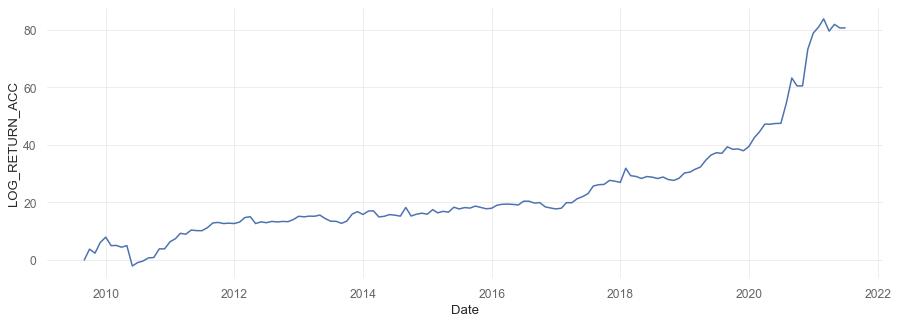

In [46]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['LOG_RETURN_ACC'])

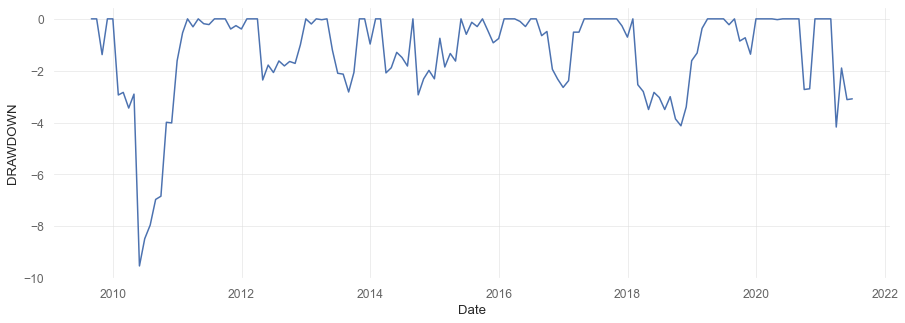

In [47]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['DRAWDOWN'])

아래 그림의 샤프 비율은 월간 데이터로 구해진 것이라 왜곡되어 있습니다. 환산시킨 9,97나 Return-Risk Ratio 0.96이 더 믿을 만 합니다.

In [49]:
quantstats.stats.sharpe(df_asset['RETURN'])/math.sqrt(252/12)

0.9663908195509003

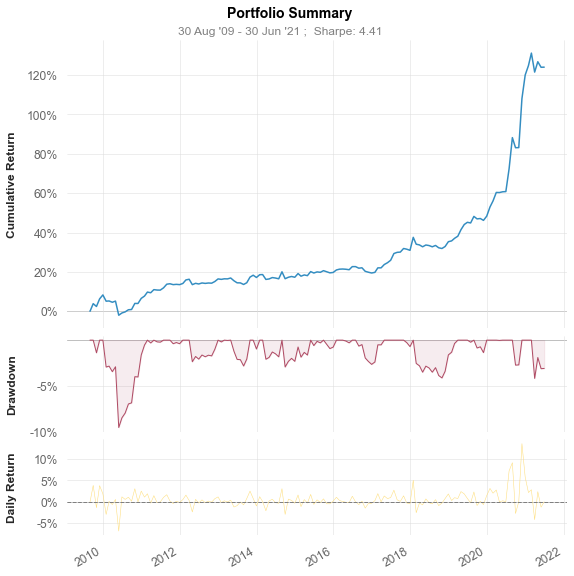

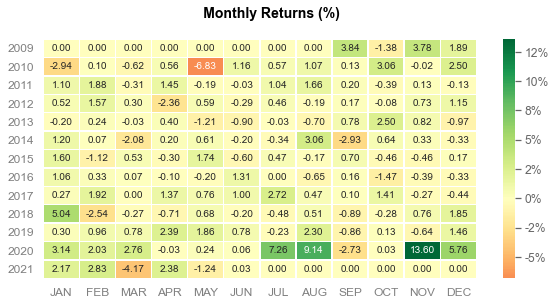

In [48]:
quantstats.reports.plots(df_asset['RETURN']/100, mode='basic')

벤치마크 느낌으로 SPTI를 한번 보겠습니다. 일별 데이터로 가져오니 quantstats 라이브러리 그대로 써도 됩니다. FinanceDataReader로 가져온 데이터에 따르면 연 복리 1% 수익이었습니다. 변동성 3.06%, MDD -6.73%, 샤프 비율 0.35로 정크본드와 전환사채를 넣은 오늘의 전략보다 많이 못하긴 합니다. 심지어 오늘 만든 전략에서 가장 좋은 4개월을 빼더라도 SPTI는 가볍게 이기는 것으로 보입니다. 

In [66]:
spti_bm = fdr.DataReader('SPTI', '2009-07-31', '2021-06-30')['Close']
spti_bm = spti_bm.pct_change(periods=1)
spti_bm = spti_bm.dropna()
spti_bm

Date
2009-08-03   -0.005232
2009-08-04   -0.000701
2009-08-05   -0.003158
2009-08-06    0.000000
2009-08-07   -0.002112
                ...   
2021-06-24    0.000309
2021-06-25   -0.001546
2021-06-28    0.002168
2021-06-29    0.000000
2021-06-30    0.000618
Name: Close, Length: 3023, dtype: float64

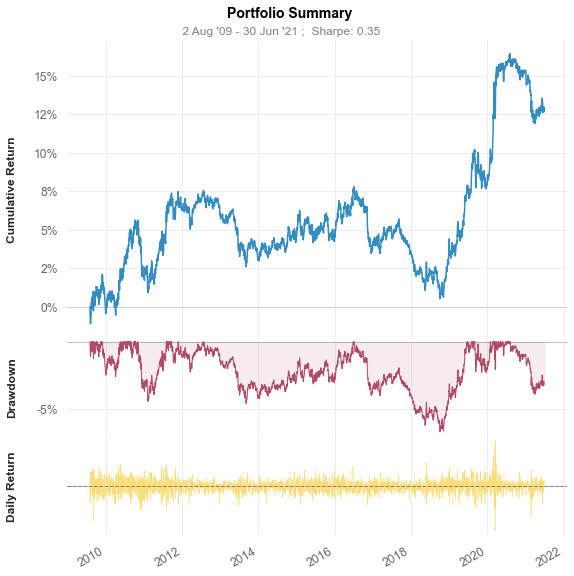

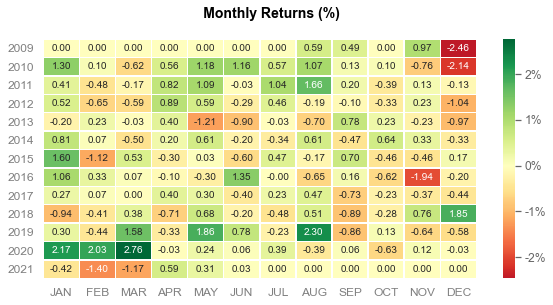

In [69]:
quantstats.reports.plots(spti_bm, mode='basic')

In [70]:
quantstats.reports.metrics(spti_bm, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2009-08-03
End Period                 2021-06-30
Risk-Free Rate             0.0%
Time in Market             91.0%

Cumulative Return          12.94%
CAGR%                      1.03%
Sharpe                     0.35
Sortino                    0.5
Max Drawdown               -6.73%
Longest DD Days            1432
Volatility (ann.)          3.06%
Calmar                     0.15
Skew                       0.03
Kurtosis                   4.47

Expected Daily %           0.0%
Expected Monthly %         0.09%
Expected Yearly %          0.94%
Kelly Criterion            3.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.31%
Expected Shortfall (cVaR)  -0.31%

Payoff Ratio               0.99
Profit Factor              1.06
Common Sense Ratio         1.06
CPC Index                  0.54
Tail Ratio                 1.0
Outlier Win Ratio          4.09
Outlier Loss Ratio         3.37

MT